# Generative Adversarial Network for Augmentation of Laser-Based Laryngeal Imaging

For the deep-learning-based algorithm to match features via a registration task, it is essential to apply intense data augmentation to the training data set. As displayed in the following figure the training data consists of images $m(x)$ that represent the spatial configuration of laser points projected onto the vocal fold surface.

![alt text here](images/feature_matching_registration.png "Logo Title Jupyter Notebook logo")

The foundation for the images $m(x)$ are the x-y-coordinates of each single laser point within the image, as $m(x)$ is generated by plotting the single laser points and then smoothing the image. To create intense augmentation we want to train a generative adversaraial network (GAN) to then generate images that are variations of the images of the training set and represent feasible configurations of laser points projected onto a vocal fold. The implementation of the GAN is inspired by Chollet [1].

[1]F. Chollet, Deep Learning with Python, 1st ed. Shelter Island, New York: Manning Publications, 2017.


## Import Statements
The notebook was developed on Keras using the Tensorflow 2.2.0 backend.

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
import glob
import json

## Hardware Configuration
Check for GPU and allow memory growth such that limitations for training are reduced. 

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Model parameters
The grid dimensions have to be know, as well as the image dimensions for scaling. The depth of the input and output layer is 2 here, as we will have one channel representing x-coordinates and a second channel representing y-coordinates. 

In [3]:
height = 18
width = 18
channels = 2

image_width = 728
image_height = 728

## Hyperparameters
The dimension of the latent space can be adapted to optimize the network. 

In [4]:
latent_dim = 8
kernel_size = 4
filters = 128

## Generator
The first part of a GAN is a generator network that takes random input vectors from the latent space and decodes the vector to generate a synthetic image.

In [5]:
generator_input = keras.Input(shape=(latent_dim,))

# Leaky ReLU is preferred as it lowers the sparsity of gradients
x = layers.Dense(filters * (height//2) * (width//2))(generator_input)
x = layers.BatchNormalization()(x, training=True) #layers.BatchNormalization(virtual_batch_size=4)(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(((height//2), (width//2), filters))(x)

# Kernel size should be divisible by the stride size to prevent checkerboard artifacts
x = layers.Conv2DTranspose(2*filters, kernel_size, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x, training=True)
x = layers.LeakyReLU()(x)


# Use tanh activation for improved training
x = layers.Conv2D(channels, kernel_size, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 10368)             93312     
_________________________________________________________________
batch_normalization (BatchNo (None, 10368)             41472     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10368)             0         
_________________________________________________________________
reshape (Reshape)            (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 18, 18, 256)       524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 18, 256)       1024  

## Discriminator
The second part of the GAN is a discriminator network that takes an image as input and decides if the image comes from the training set or was synthetically created by the generator.

In [6]:
height=18
width=18
channels=2

discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(filters, kernel_size)(discriminator_input)
x = layers.LeakyReLU()(x)

# Use strided convolutions instead of max pooling as it lowers the sparsity of gradients
x = layers.Conv2D(filters, kernel_size, strides=2)(x)
x = layers.BatchNormalization()(x, training=True)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters, kernel_size, strides=2)(x)
x = layers.BatchNormalization()(x, training=True)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

# Dropout is essential to induce robustness to the GAN
x = layers.Dropout(0.5)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

#discriminator_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0, decay=1e-8)
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8)


discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18, 18, 2)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       4224      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         2622

## GAN
The gan itself is composed by the generator and the discriminator.

In [7]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
x = discriminator(x)
gan = keras.models.Model(gan_input, x)

#gan_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0, decay=1e-8)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)

gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### Prepare data
Load the data and scale them to be between 0.0 an 1.0. Further use zero-padding to get a 20x20 shape for this example. We use the already augmented data here for providing a large training set.

In [8]:
x_position = np.load('data/x_pos_LASTEN2.npy')
y_position = np.load('data/y_pos_LASTEN2.npy')

offset = 0.0

# Non existing points mapping
x_position = np.where(x_position<=0, -offset, x_position) + offset
y_position = np.where(x_position<=0, -offset, y_position) + offset

x_position = x_position / (image_width + offset)
y_position = y_position / (image_height + offset)

x_position = x_position[:,:,:,np.newaxis]
y_position = y_position[:,:,:,np.newaxis]

xy_data = np.concatenate((x_position, y_position), axis=3)
print("Shape of 'xy_data': {}".format(xy_data.shape))

Shape of 'xy_data': (160, 18, 18, 2)


## GAN Training
The training of the DCGAN (Deep Convolutional Generative Adversarial Network) is a dynamic process, where an equilibrium between capability of the generator to fake images and the capability of the discriminator to recognize faked images should be achieved. The procedure of training is iterative. The following steps are repeated until a sufficient equilibrium is achieved:

1. We randomly draw points from the latent space assuming a Gaussian distribution.
2. The sample points from 1. are used to generate images with the generator.
3. Generated images (fake) are mixed with images from the trainin set (real).
4. Only the discriminator is trained where fake images get the label "fake" and real images have the label "real". In that way the disciminator learns to judge the generator whether is provided image is fake or real.
5. Again draw random points from the latent space.
6. The points from 5. are labeled as "real" images (although they are not) the parameters of the discriminator are fixed and the whole GAN model is trained. In that way the generator learns to fake images.

In [9]:
iterations = 40
batch_size = 40
save_dir = 'weights/gan'

np.random.shuffle(xy_data)

start = 0
for step in range(iterations):
    # Get random 'fake' images
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # sample with mean=0 and std=1.0
    generated_images = generator.predict(random_latent_vectors)
    
    # Get 'real' images, merge them with 'fake' and create labels
    stop = start + batch_size
    real_images = xy_data[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)) - 0.1,
                             np.zeros((batch_size, 1))])
    
    labels += 0.05 * np.random.random(labels.shape) # important to introduce some randomness
    
    # Train the discriminator on 'real' and 'fake' images
    d_loss = discriminator.train_on_batch(combined_images, labels)
    #d_loss = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)) - 0.1)
    #d_loss = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 1)))

    # Get random images from generator but treat them as 'real' now
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    
    # Train the generator's weights
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    # Finalize loop
    start += batch_size
    if start > len(xy_data) - batch_size:
        start = 0
        np.random.shuffle(xy_data)
        
    if step % 2 == 0:
        gan.save_weights('gan.h5')
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
        
        gen = generated_images[0,:,:,0][:,:,np.newaxis]
        real = real_images[0,:,:,0][:,:,np.newaxis]
        
        img = image.array_to_img(gen * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated' + str(step) + '.png'))
        
        img = image.array_to_img(real * 255., scale=False)
        img.save(os.path.join(save_dir, 'real' + str(step) + '.png'))

discriminator loss: 1.0468679666519165
adversarial loss: 0.8020842671394348
discriminator loss: 1.384063959121704
adversarial loss: 0.7503725290298462
discriminator loss: 0.2101483792066574
adversarial loss: 0.7367242574691772
discriminator loss: 0.25058093667030334
adversarial loss: 0.7771723866462708
discriminator loss: 0.23903736472129822
adversarial loss: 0.7824015617370605
discriminator loss: 0.19089804589748383
adversarial loss: 0.7948578596115112
discriminator loss: 0.21052134037017822
adversarial loss: 0.8416889905929565
discriminator loss: 0.22879579663276672
adversarial loss: 0.8546603322029114
discriminator loss: 0.2120143473148346
adversarial loss: 0.8468030095100403
discriminator loss: 0.20543615520000458
adversarial loss: 0.8535431027412415
discriminator loss: 0.20849700272083282
adversarial loss: 0.843746542930603
discriminator loss: 0.20494718849658966
adversarial loss: 0.8767075538635254
discriminator loss: 0.2589438259601593
adversarial loss: 0.8156614303588867
discri

In [10]:
xy_data.shape

(160, 18, 18, 2)

## Visualize resultsm
A randomly drawn latent vector is used to generate a fake image by the generator.

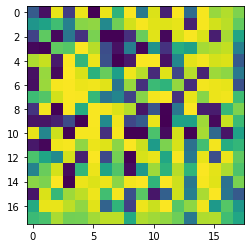

In [11]:
random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))# sample with mean=0 and std=1.0
    
generated_images = generator.predict(random_latent_vectors)
generated_images *= 255

for i in range(1):
    img = generated_images[i,:,:,0]
    img = img[:,:,np.newaxis]
    img = keras.preprocessing.image.array_to_img(img)
    plt.imshow(img)

from numba import cuda
cuda.select_device(0)
cuda.close()